# Redes Neurais Recorrentes

In [1]:
# Python ≥3.5 é necessário
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 é necessário
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    %tensorflow_version 2.x
except Exception:
    pass

# TensorFlow ≥2.0 é necessário
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

# imports comuns
import numpy as np
import os

# tornar os resultados reproduzíveis
np.random.seed(42)
tf.random.set_seed(42)

# Para apresentar figuras
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

### Geração de um conjunto de dados

In [2]:
def generate_time_series(batch_size, n_steps):
    freq1, freq2, offsets1, offsets2 = np.random.rand(4, batch_size, 1)
    time = np.linspace(0, 1, n_steps)
    series = 0.5 * np.sin((time - offsets1) * (freq1 * 10 + 10))  #   onda 1
    series += 0.2 * np.sin((time - offsets2) * (freq2 * 20 + 20)) # + onda 2
    series += 0.1 * (np.random.rand(batch_size, n_steps) - 0.5)   # + ruído
    return series[..., np.newaxis].astype(np.float32)

In [3]:
np.random.seed(42)

n_steps = 50
series = generate_time_series(10000, n_steps + 1)
X_train, y_train = series[:7000, :n_steps], series[:7000, -1]
X_valid, y_valid = series[7000:9000, :n_steps], series[7000:9000, -1]
X_test, y_test = series[9000:, :n_steps], series[9000:, -1]

In [4]:
X_train.shape, y_train.shape

((7000, 50, 1), (7000, 1))

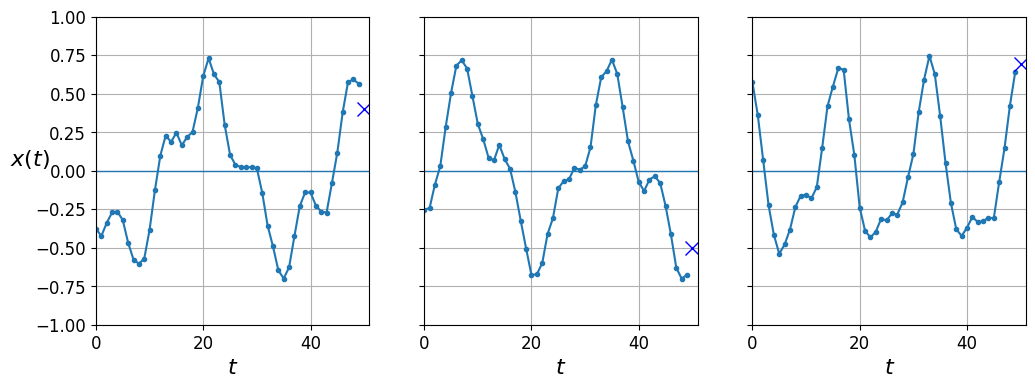

In [5]:
def plot_series(series, y=None, y_pred=None, x_label="$t$", y_label="$x(t)$"):
    plt.plot(series, ".-")
    if y is not None:
        plt.plot(n_steps, y, "bx", markersize=10)
    if y_pred is not None:
        plt.plot(n_steps, y_pred, "ro")
    plt.grid(True)
    if x_label:
        plt.xlabel(x_label, fontsize=16)
    if y_label:
        plt.ylabel(y_label, fontsize=16, rotation=0)
    plt.hlines(0, 0, 100, linewidth=1)
    plt.axis([0, n_steps + 1, -1, 1])

fig, axes = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(12, 4))
for col in range(3):
    plt.sca(axes[col])
    plot_series(X_valid[col, :, 0], y_valid[col, 0],
                y_label=("$x(t)$" if col==0 else None))
plt.show()

## Construção de uma rede neural simples

In [6]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(1, input_shape={None, 1})
])

optimizer = keras.optimizers.Adam(learning_rate=0.005)
model.compile(loss="mse", optimizer=optimizer)
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

Epoch 1/20


c:\Users\lucas\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0212 - val_loss: 0.0109
Epoch 2/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0115 - val_loss: 0.0109
Epoch 3/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0115 - val_loss: 0.0109
Epoch 4/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0115 - val_loss: 0.0109
Epoch 5/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0115 - val_loss: 0.0109
Epoch 6/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0115 - val_loss: 0.0109
Epoch 7/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0115 - val_loss: 0.0109
Epoch 8/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0115 - val_loss: 0.0109
Epoch 9/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0115 - val_loss: 0.0109
Epoch 10/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0115 - val_loss: 0.0109
Epoch 11/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0115 - val_loss: 0.0109
Epoch 12/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.

In [7]:
model.evaluate(X_valid, y_valid)

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0110


0.010956202633678913

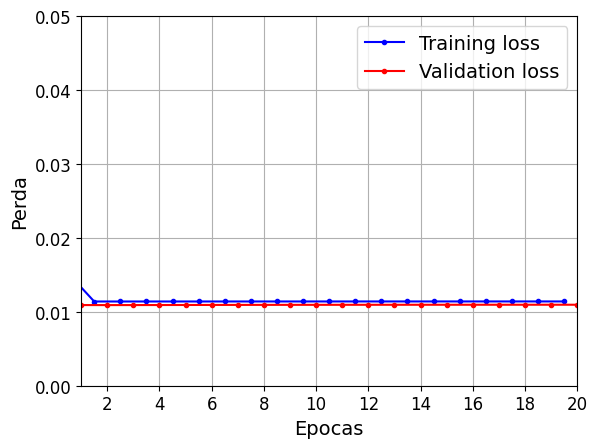

In [8]:
def plot_learning_curves(loss, val_loss):
    plt.plot(np.arange(len(loss)) + 0.5, loss, "b.-", label="Training loss")
    plt.plot(np.arange(len(val_loss)) + 1, val_loss, "r.-", label="Validation loss")
    plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
    plt.axis([1, 20, 0, 0.05])
    plt.legend(fontsize=14)
    plt.xlabel("Epocas")
    plt.ylabel("Perda")
    plt.grid(True)

plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


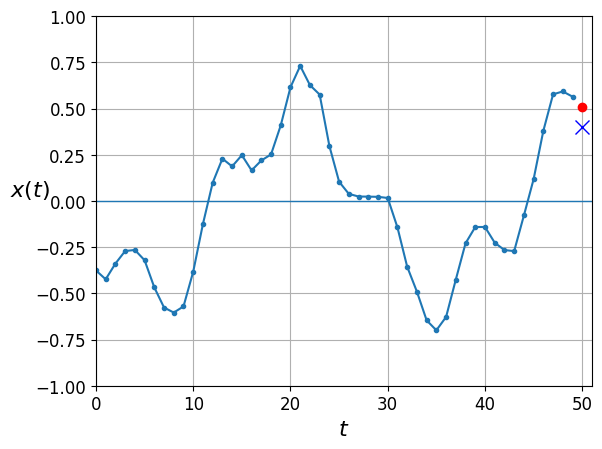

In [9]:
y_pred = model.predict(X_valid)
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

## Construção de uma rede neural profunda

In [10]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20, return_sequences=True),
    keras.layers.SimpleRNN(1)
])

model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

Epoch 1/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 0.0373 - val_loss: 0.0058
Epoch 2/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0054 - val_loss: 0.0042
Epoch 3/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0044 - val_loss: 0.0037
Epoch 4/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0040 - val_loss: 0.0034
Epoch 5/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0037 - val_loss: 0.0033
Epoch 6/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0036 - val_loss: 0.0032
Epoch 7/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0034 - val_loss: 0.0031
Epoch 8/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0033 - val_loss: 0.0031
Epoch 9/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0033 - val_loss: 0.0031
Epoch 10/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0032 - val_loss: 0.0031
Epoch 11/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0031 - val_loss: 0.0032
Epoch 12/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/ste

In [11]:
model.evaluate(X_valid, y_valid)

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0031


0.0031857879366725683

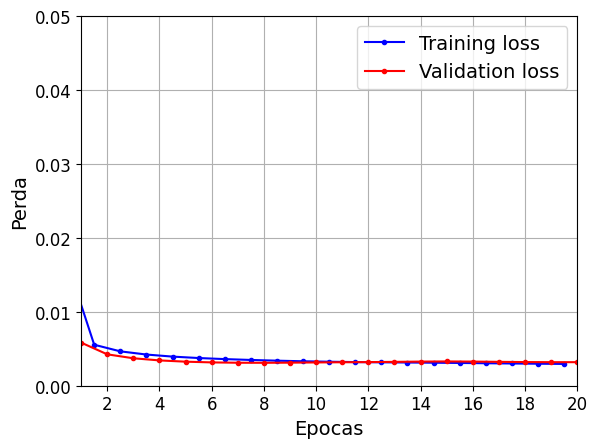

In [12]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


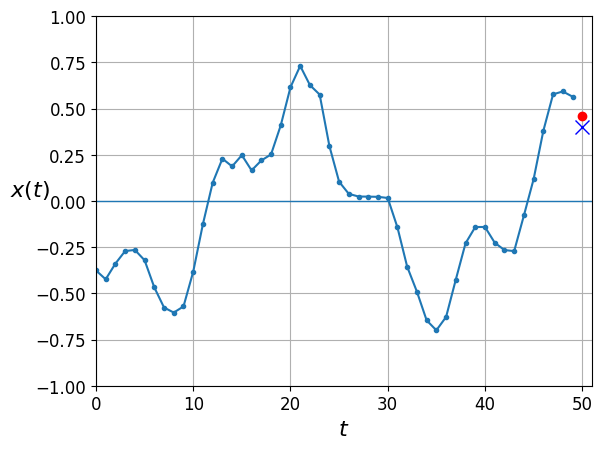

In [13]:
y_pred = model.predict(X_valid)
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

## Previsão de valores

In [14]:
np.random.seed(43) 

series = generate_time_series(1, n_steps + 10)
X_new, Y_new = series[:, :n_steps], series[:, n_steps:]
X = X_new
for step_ahead in range(10):
    y_pred_one = model.predict(X[:, step_ahead:])[:, np.newaxis, :]
    X = np.concatenate([X, y_pred_one], axis=1)

Y_pred = X[:, n_steps:]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


In [15]:
Y_pred.shape

(1, 10, 1)

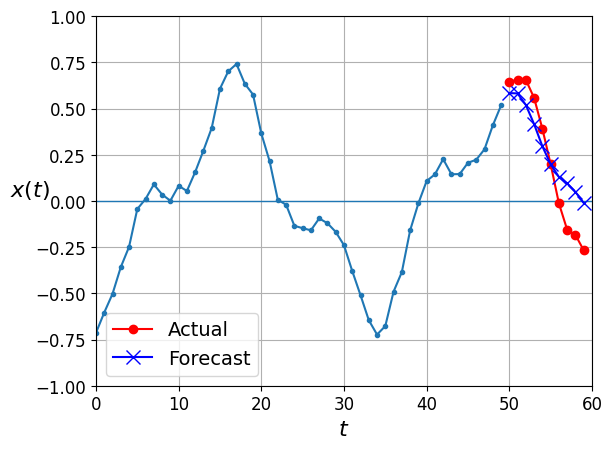

In [16]:
def plot_multiple_forecasts(X, Y, Y_pred):
    n_steps = X.shape[1]
    ahead = Y.shape[1]
    plot_series(X[0, :, 0])
    plt.plot(np.arange(n_steps, n_steps + ahead), Y[0, :, 0], "ro-", label="Actual")
    plt.plot(np.arange(n_steps, n_steps + ahead), Y_pred[0, :, 0], "bx-", label="Forecast", markersize=10)
    plt.axis([0, n_steps + ahead, -1, 1])
    plt.legend(fontsize=14)

plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()

**Agora vamos usar este modelo para prever os próximos 10 valores. Primeiro nós regeramos as sequências, com dez passos a mais.**

In [17]:
np.random.seed(42)

n_steps = 50
series = generate_time_series(10000, n_steps + 10)
X_train, Y_train = series[:7000, :n_steps], series[:7000, -10:, 0]
X_valid, Y_valid = series[7000:9000, :n_steps], series[7000:9000, -10:, 0]
X_test, Y_test = series[9000:, :n_steps], series[9000:, -10:, 0]

Agora, prevemos os próximos 10 valores um por um.

In [18]:
X = X_valid
for step_ahead in range(10):
    y_pred_one = model.predict(X)[:, np.newaxis, :]
    X = np.concatenate([X, y_pred_one], axis=1)

Y_pred = X[:, n_steps:, 0]

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


In [19]:
Y_pred.shape

(2000, 10)

In [22]:
np.mean(tf.reduce_mean(tf.square(Y_valid, Y_pred)))

0.14601564

Vamos comparar o desempenho com alguns baselines: previsão naive e modelo linear simples.

In [23]:
Y_naive_pred = Y_valid[:, -1:]
np.mean(tf.reduce_mean(tf.square(Y_valid, Y_naive_pred)))

0.14601564

In [24]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[50, 1]),
    keras.layers.Dense(10)
])

model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20


c:\Users\lucas\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 860us/step - loss: 0.2129 - val_loss: 0.0698
Epoch 2/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 600us/step - loss: 0.0612 - val_loss: 0.0463
Epoch 3/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 593us/step - loss: 0.0439 - val_loss: 0.0380
Epoch 4/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 584us/step - loss: 0.0369 - val_loss: 0.0334
Epoch 5/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 647us/step - loss: 0.0327 - val_loss: 0.0303
Epoch 6/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 544us/step - loss: 0.0298 - val_loss: 0.0281
Epoch 7/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 615us/step - loss: 0.0277 - val_loss: 0.0264
Epoch 8/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 593us/step - loss: 0.0261 - val_loss: 0.0252
Epoch 9/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 641us/step - loss: 0.0249 - val_loss: 0.0242
Epoch 10/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 543us/step - loss: 0.0239 - val_loss: 0.0234
Epoch 11/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 641us/step - loss: 0.0231 - val_loss: 0.0227
Epoch 12/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 

In [25]:
model.evaluate(X_valid, y_valid)

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 393us/step - loss: 0.2047


0.203089639544487

**Agora vamos criar uma RNN que prevê 10 valores em um único passo.**

In [26]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20),
    keras.layers.Dense(10)
])

model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20


c:\Users\lucas\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


219/219 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.1110 - val_loss: 0.0268
Epoch 2/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0244 - val_loss: 0.0184
Epoch 3/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0178 - val_loss: 0.0167
Epoch 4/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0148 - val_loss: 0.0146
Epoch 5/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0131 - val_loss: 0.0135
Epoch 6/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0120 - val_loss: 0.0138
Epoch 7/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0113 - val_loss: 0.0132
Epoch 8/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0108 - val_loss: 0.0121
Epoch 9/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0104 - val_loss: 0.0107
Epoch 10/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0101 - val_loss: 0.0097
Epoch 11/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0099 - val_loss: 0.0093
Epoch 12/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.

In [27]:
np.random.seed(43)

series = generate_time_series(1, 50 + 10)
X_new, Y_new = series[:, :50, :], series[:, -10:, :]
Y_pred = model.predict(X_new)[..., np.newaxis]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 329ms/step


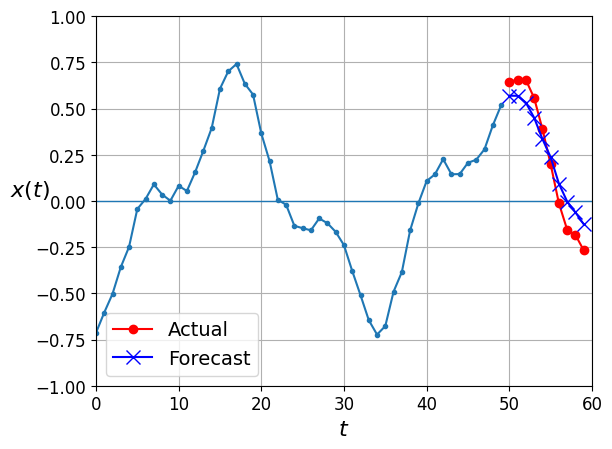

In [28]:
plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()

Agora vamos criar uma RNN que prevê os próximos 10 valores a cada passo de tempo, ou seja, ao invés de apenas prever os passos de 50 a 59 baseado nos passos 40 a 49, a RNN irá prever os passos de 1 a 10 no tempo 0, os passos de 2 a 11 no tempo 1, e assim sucessivamente, até prever os passos 50 a 59 no último intervalo de tempo.

In [29]:
np.random.seed(42)

n_steps = 50
series = generate_time_series(10000, n_steps + 10)
X_train = series[:7000, :n_steps]
X_valid = series[7000:9000, :n_steps]
X_test = series[9000:, :n_steps]
Y = np.empty((10000, n_steps, 10))
for step_ahead in range(1, 10 + 1):
    Y[..., step_ahead - 1] = series[..., step_ahead:step_ahead + n_steps, 0]
Y_train = Y[:7000]
Y_valid = Y[7000:9000]
Y_test = Y[9000:]

In [30]:
X_train.shape, Y_train.shape

((7000, 50, 1), (7000, 50, 10))

In [37]:
#import numpy as np
#import tensorflow as tf
#from tensorflow import keras

np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

def last_time_step_mse(Y_true, Y_pred):
    return tf.reduce_mean(tf.square(Y_true[:, -1] - Y_pred[:, -1]))

model.compile(loss="mse", optimizer=keras.optimizers.Adam(learning_rate=0.01), metrics=[last_time_step_mse])

history = model.fit(X_train, Y_train, epochs=20, validation_data=(X_valid, Y_valid))


Epoch 1/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - last_time_step_mse: 0.0847 - loss: 0.0923 - val_last_time_step_mse: 0.0253 - val_loss: 0.0397
Epoch 2/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - last_time_step_mse: 0.0265 - loss: 0.0396 - val_last_time_step_mse: 0.0230 - val_loss: 0.0359
Epoch 3/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - last_time_step_mse: 0.0219 - loss: 0.0344 - val_last_time_step_mse: 0.0165 - val_loss: 0.0299
Epoch 4/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - last_time_step_mse: 0.0180 - loss: 0.0305 - val_last_time_step_mse: 0.0157 - val_loss: 0.0283
Epoch 5/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - last_time_step_mse: 0.0162 - loss: 0.0284 - val_last_time_step_mse: 0.0143 - val_loss: 0.0263
Epoch 6/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - last_time_step_mse: 0.0154 - loss: 0.0275 - val_last_time_step_mse: 0.0130 - val_loss: 0.0251
Epoch 7/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - last_time_step_mse: 0.0146 - loss: 0.0267 - val_last_time_

In [38]:
np.random.seed(43)

series = generate_time_series(1, 50 + 10)
X_new, Y_new = series[:, :50, :], series[:, 50:, :]
Y_pred = model.predict(X_new)[:, -1][..., np.newaxis]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 340ms/step


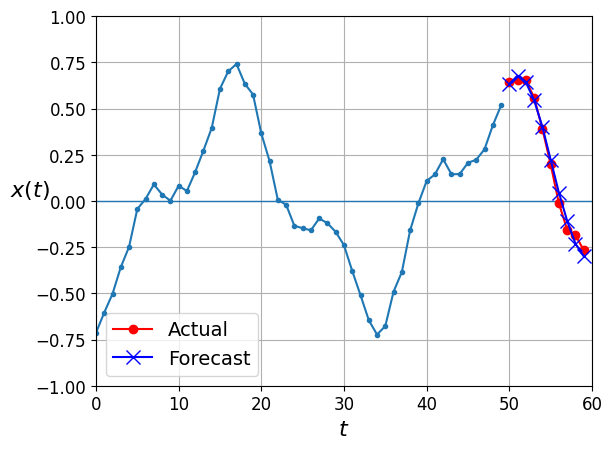

In [39]:
plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()